In [ ]:
import os
import warnings
import numpy as np
import pandas as pd

# -----------------------------
# Configuration
# -----------------------------
BASE_DIR = r"\\Sherwood\accounting\Share\Finance Meetings & Reports\Monthly Reports\BCM Report Monthly\Power BI Report\Forecasting Method - Prophet"
OUTPUT_DIR = os.path.join(BASE_DIR, "Output")

# Ensure output folder exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

FILENAME = "data_input_monthly.csv"
PATH = os.path.join(BASE_DIR, FILENAME)

# Write outputs to Output\
OUT_BACKTEST_DETAIL  = os.path.join(OUTPUT_DIR, "backtest_detail.csv")
OUT_BACKTEST_SUMMARY = os.path.join(OUTPUT_DIR, "backtest_summary.csv")
OUT_FORECAST_ALL     = os.path.join(OUTPUT_DIR, "forecast_all_models_18m.csv")
OUT_FORECAST_WINNER  = os.path.join(OUTPUT_DIR, "forecast_winner_18m.csv")
OUT_FY_TOTALS        = os.path.join(OUTPUT_DIR, "forecast_fy_totals.csv")


DATE_COL = "ACC_MONTH"
Y_COL = "TOT_PAID"
EXOG_COLS = ["BUDGET_AMT", "NBR_MURDER"]

H = 18  # months forecast horizon

POST_START = pd.Timestamp("2021-04-01")

# FY2020-21 outlier period (inclusive month starts)
OUTLIER_START = pd.Timestamp("2020-04-01")
OUTLIER_END   = pd.Timestamp("2021-03-01")

MIN_CUTOFF = POST_START
LAG_MIN, LAG_MAX = 0, 12

# Rolling training window length
TRAIN_WINDOW_MONTHS = 60
MIN_TRAIN_MONTHS = 36  # safety minimum

# Seasonal Moving Average parameters
SEASONAL_MA_YEARS = 3

OUT_BACKTEST_DETAIL = os.path.join(BASE_DIR, "backtest_detail.csv")
OUT_BACKTEST_SUMMARY = os.path.join(BASE_DIR, "backtest_summary.csv")
OUT_FORECAST_ALL = os.path.join(BASE_DIR, "forecast_all_models_18m.csv")
OUT_FORECAST_WINNER = os.path.join(BASE_DIR, "forecast_winner_18m.csv")
OUT_FY_TOTALS = os.path.join(BASE_DIR, "forecast_fy_totals.csv")

# -----------------------------
# Optional dependencies
# -----------------------------
PROPHET_AVAILABLE = False
try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
except Exception:
    PROPHET_AVAILABLE = False

STATSMODELS_AVAILABLE = False
try:
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    STATSMODELS_AVAILABLE = True
except Exception:
    STATSMODELS_AVAILABLE = False


# -----------------------------
# Safe CSV writer (handles PermissionError on network share)
# -----------------------------
def safe_to_csv(df_: pd.DataFrame, path: str, **kwargs) -> str:
    try:
        df_.to_csv(path, **kwargs)
        return path
    except PermissionError:
        fallback = os.path.join(os.getcwd(), os.path.basename(path))
        df_.to_csv(fallback, **kwargs)
        print(f"\n⚠️ PermissionError writing to:\n  {path}\nSaved to local fallback:\n  {fallback}\n")
        return fallback


# -----------------------------
# Metrics (robust to NaNs)
# -----------------------------
def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    if m.sum() == 0:
        return np.nan
    yt = y_true[m]
    yp = y_pred[m]
    denom = (np.abs(yt) + np.abs(yp))
    denom[denom == 0] = np.nan
    return np.nanmean(200.0 * np.abs(yp - yt) / denom)

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    if m.sum() == 0:
        return np.nan
    return np.sqrt(np.nanmean((y_pred[m] - y_true[m]) ** 2))

def mase(y_true, y_pred, y_train, m=12):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    y_train = np.asarray(y_train, dtype=float)

    mt = np.isfinite(y_true) & np.isfinite(y_pred)
    if mt.sum() == 0:
        return np.nan

    y_train = y_train[np.isfinite(y_train)]
    if len(y_train) <= m:
        return np.nan
    denom = np.nanmean(np.abs(y_train[m:] - y_train[:-m]))
    if denom == 0 or np.isnan(denom):
        return np.nan
    return np.nanmean(np.abs(y_true[mt] - y_pred[mt])) / denom

# ---- Bias metrics (computed on the 18-month TEST window) ----
def mean_error(y_true, y_pred):
    """Mean Error (ME): average(pred - actual) in $ units."""
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    if m.sum() == 0:
        return np.nan
    return float(np.nanmean(y_pred[m] - y_true[m]))

def bias_wape(y_true, y_pred):
    """
    Bias as % of total actual magnitude (WAPE-style):
      100 * sum(pred-actual) / sum(|actual|)
    Interpretable for totals, stable for PowerBI.
    """
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    if m.sum() == 0:
        return np.nan
    denom = np.nansum(np.abs(y_true[m]))
    if denom == 0 or np.isnan(denom):
        return np.nan
    return float(100.0 * (np.nansum(y_pred[m] - y_true[m]) / denom))


# -----------------------------
# Fiscal helpers
# -----------------------------
def fy_start_year(dt: pd.Timestamp) -> int:
    return dt.year if dt.month >= 4 else dt.year - 1

def fiscal_year_label(dt: pd.Timestamp) -> str:
    y = fy_start_year(dt)
    return f"FY{y}-{str(y+1)[-2:]}"


# -----------------------------
# Read & prepare data
# -----------------------------
df = pd.read_csv(PATH)
df.columns = [c.strip() for c in df.columns]

required = [DATE_COL, Y_COL] + EXOG_COLS
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
df = df.dropna(subset=[DATE_COL]).copy()

# Normalize to monthly START timestamps
df[DATE_COL] = df[DATE_COL].dt.to_period("M").dt.to_timestamp(how="start")
df = df.sort_values(DATE_COL).reset_index(drop=True)

for c in [Y_COL] + EXOG_COLS:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.set_index(DATE_COL).sort_index()
df = df.asfreq("MS")  # enforce monthly start grid

# POST dummy from index (never NaN)
df["POST"] = (df.index >= POST_START).astype(int)

# -----------------------------
# Outlier handling: fill FY2020-21 with moving average of past 24 months
# -----------------------------
def fill_outlier_with_past_ma(s: pd.Series, start: pd.Timestamp, end: pd.Timestamp, window_months: int = 24) -> pd.Series:
    s = s.astype(float).copy()
    outlier_idx = s.loc[start:end].index
    for d in outlier_idx:
        hist_end = d - pd.DateOffset(months=1)
        hist_start = d - pd.DateOffset(months=window_months)
        hist = s.loc[hist_start:hist_end].dropna()
        if len(hist) == 0:
            hist2 = s.loc[:hist_end].dropna()
            fill_val = float(hist2.mean()) if len(hist2) else np.nan
        else:
            fill_val = float(hist.tail(window_months).mean())
        s.loc[d] = fill_val
    return s

for c in [Y_COL] + EXOG_COLS:
    if c in df.columns:
        df[c] = fill_outlier_with_past_ma(df[c], OUTLIER_START, OUTLIER_END, window_months=24)

# Drop missing target (after fill)
df = df.dropna(subset=[Y_COL])


# -----------------------------
# Lag selection (TRAIN only)
# -----------------------------
def pick_best_lag(train_df, y=Y_COL, x="BUDGET_AMT", lag_min=0, lag_max=12):
    best_lag = 0
    best_abs = -np.inf
    yv = train_df[y].astype(float)
    xv = pd.to_numeric(train_df[x], errors="coerce")
    for lag in range(lag_min, lag_max + 1):
        xlag = xv.shift(lag)
        corr = pd.concat([yv, xlag], axis=1).corr().iloc[0, 1]
        if np.isfinite(corr) and abs(corr) > best_abs:
            best_abs = abs(corr)
            best_lag = lag
    return best_lag

def make_exog_features(base_df, lag_budget, lag_murder, post_start=POST_START):
    out = pd.DataFrame(index=base_df.index)
    out["BUDGET_L"] = pd.to_numeric(base_df["BUDGET_AMT"], errors="coerce").shift(lag_budget)
    out["MURDER_L"] = pd.to_numeric(base_df["NBR_MURDER"], errors="coerce").shift(lag_murder)
    out["POST"] = (out.index >= post_start).astype(int)
    out["POST_x_BUDGET_L"] = out["POST"] * out["BUDGET_L"]
    out["POST_x_MURDER_L"] = out["POST"] * out["MURDER_L"]
    return out


# -----------------------------
# Baseline Models
# -----------------------------
def fit_predict_seasonal_naive_recursive(train_y: pd.Series, future_index: pd.DatetimeIndex, season=12):
    hist = train_y.astype(float).copy().asfreq("MS")
    preds = []
    for d in future_index:
        ref = d - pd.DateOffset(months=season)
        val = hist.get(ref, np.nan)
        if not np.isfinite(val):
            last = hist.dropna().iloc[-1] if hist.dropna().shape[0] else 0.0
            val = last
        preds.append(float(val))
        hist.loc[d] = float(val)
    return pd.Series(preds, index=future_index, dtype=float)

def fit_predict_seasonal_moving_average(train_y: pd.Series, future_index: pd.DatetimeIndex, years=3):
    y = train_y.astype(float).asfreq("MS").dropna()
    if y.empty:
        return pd.Series(0.0, index=future_index, dtype=float)

    k = max(1, int(years))
    out = []
    for d in future_index:
        same_month = y[y.index.month == d.month]
        out.append(float(y.mean()) if same_month.empty else float(same_month.tail(k).mean()))
    return pd.Series(out, index=future_index, dtype=float)

def fit_predict_seasonal_naive_drift(train_y: pd.Series, future_index: pd.DatetimeIndex, season=12):
    y = train_y.astype(float).asfreq("MS")
    y_nonan = y.dropna()
    if len(y_nonan) == 0:
        return pd.Series(0.0, index=future_index, dtype=float)

    last_date = y_nonan.index.max()
    yT = float(y_nonan.loc[last_date])
    yT_s = y_nonan.get(last_date - pd.DateOffset(months=season), np.nan)

    drift = (yT - float(yT_s)) / float(season) if np.isfinite(yT_s) else 0.0
    base = fit_predict_seasonal_naive_recursive(y_nonan, future_index, season=season)

    out = []
    for i, d in enumerate(future_index, start=1):
        out.append(float(base.loc[d] + drift * i))
    return pd.Series(out, index=future_index, dtype=float)


# -----------------------------
# ETS (robust)
# -----------------------------
def fit_predict_ets_robust(train_y: pd.Series, test_index: pd.DatetimeIndex):
    if not STATSMODELS_AVAILABLE:
        return pd.Series(np.nan, index=test_index)

    y = train_y.astype(float).asfreq("MS").dropna()
    if len(y) < 24:
        return fit_predict_seasonal_naive_recursive(y, test_index, season=12)

    specs = [
        dict(trend="add", seasonal="add"),
        dict(trend="add", seasonal=None),
        dict(trend=None, seasonal="add"),
    ]
    if (y > 0).all():
        specs.insert(1, dict(trend="add", seasonal="mul"))

    for sp in specs:
        try:
            model = ExponentialSmoothing(
                y,
                trend=sp["trend"],
                seasonal=sp["seasonal"],
                seasonal_periods=12 if sp["seasonal"] is not None else None,
                initialization_method="estimated",
            )
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                res = model.fit(optimized=True)

            fc = res.forecast(len(test_index))
            fc = pd.Series(fc.values, index=test_index, dtype=float)
            if np.isfinite(fc.values).all():
                return fc
        except Exception:
            continue

    return fit_predict_seasonal_naive_recursive(y, test_index, season=12)


# -----------------------------
# Prophet helpers
# -----------------------------
def prophet_univar_forecast(train_series: pd.Series, future_index: pd.DatetimeIndex):
    if not PROPHET_AVAILABLE:
        raise RuntimeError("Prophet not available. pip install prophet")

    s = train_series.astype(float).dropna()
    if len(s) < 12:
        return fit_predict_seasonal_naive_recursive(s, future_index, season=12)

    train_df = s.reset_index()
    train_df.columns = ["ds", "y"]

    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode="additive",
    )
    m.fit(train_df)

    fut = pd.DataFrame({"ds": future_index})
    pred = m.predict(fut)["yhat"].values
    return pd.Series(pred, index=future_index, dtype=float)

def prophet_univar_totpaid(train_y: pd.Series, test_index: pd.DatetimeIndex):
    return prophet_univar_forecast(train_y, test_index)

def _ensure_future_regressor(train_series: pd.Series, future_index: pd.DatetimeIndex):
    s = train_series.astype(float).asfreq("MS")
    fc = pd.Series(np.nan, index=future_index, dtype=float)

    if PROPHET_AVAILABLE:
        try:
            fc = prophet_univar_forecast(s, future_index)
        except Exception:
            fc = pd.Series(np.nan, index=future_index, dtype=float)

    if not np.isfinite(fc.values).all():
        sn = fit_predict_seasonal_naive_recursive(s.dropna(), future_index, season=12)
        fc = fc.where(np.isfinite(fc), sn)

    if not np.isfinite(fc.values).all():
        last = s.dropna().iloc[-1] if s.dropna().shape[0] else 0.0
        fc = fc.fillna(last)

    return fc.astype(float)

def prophet_regressors_with_reg_forecasts(train_df, test_index, lag_budget, lag_murder):
    if not PROPHET_AVAILABLE:
        raise RuntimeError("Prophet not available. pip install prophet")

    train_df = train_df.copy().asfreq("MS")

    bud_future = _ensure_future_regressor(train_df["BUDGET_AMT"], test_index)
    mur_future = _ensure_future_regressor(train_df["NBR_MURDER"], test_index)

    full_index = pd.date_range(train_df.index.min(), test_index.max(), freq="MS")
    base = pd.DataFrame(index=full_index)

    base["BUDGET_AMT"] = train_df["BUDGET_AMT"].reindex(full_index)
    base["NBR_MURDER"] = train_df["NBR_MURDER"].reindex(full_index)

    base.loc[test_index, "BUDGET_AMT"] = bud_future.values
    base.loc[test_index, "NBR_MURDER"] = mur_future.values

    base["BUDGET_AMT"] = base["BUDGET_AMT"].interpolate(limit_direction="both")
    base["NBR_MURDER"] = base["NBR_MURDER"].interpolate(limit_direction="both")

    exog_all = make_exog_features(base, lag_budget, lag_murder).ffill().bfill()

    y_series = train_df[Y_COL].astype(float).rename("y")
    y_series.index.name = "ds"

    exog_train = exog_all.loc[train_df.index].copy()
    exog_train.index.name = "ds"

    p_train = pd.concat([y_series, exog_train], axis=1).dropna().reset_index()
    if p_train.shape[0] < 24:
        return prophet_univar_totpaid(train_df[Y_COL], test_index)

    reg_cols = ["BUDGET_L", "MURDER_L", "POST", "POST_x_BUDGET_L", "POST_x_MURDER_L"]

    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode="additive",
    )
    for r in reg_cols:
        m.add_regressor(r, prior_scale=0.2)

    m.fit(p_train[["ds", "y"] + reg_cols])

    exog_future = exog_all.loc[test_index].copy()
    exog_future.index.name = "ds"
    p_future = exog_future.reset_index()

    pred = m.predict(p_future)[["ds", "yhat"]].set_index("ds")["yhat"].astype(float)
    return pred.reindex(test_index)


# -----------------------------
# Build rolling-origin cutoffs (POST only, horizon H)
# -----------------------------
all_months = df.index.dropna()
last_date = all_months.max()

cutoffs = []
for d in all_months:
    if d < MIN_CUTOFF:
        continue
    if d + pd.DateOffset(months=H) <= last_date:
        cutoffs.append(d)

if len(cutoffs) == 0:
    raise ValueError("No valid cutoffs for post-break CV. Check date range and H.")


# -----------------------------
# Backtest loop
# -----------------------------
detail_rows = []

def _record(cutoff, train_start, train_end, test_start, test_end, model, lag_budget, lag_murder, y_train, y_test, pred, err=None):
    ok = bool(np.isfinite(np.asarray(pred, dtype=float)).all()) and (len(pred) == len(y_test))
    return {
        "cutoff": cutoff,
        "train_start": train_start,
        "train_end": train_end,
        "test_start": test_start,
        "test_end": test_end,
        "model": model,
        "lag_budget": lag_budget,
        "lag_murder": lag_murder,
        "sMAPE": smape(y_test.values, pred.values),
        "RMSE": rmse(y_test.values, pred.values),
        "MASE": mase(y_test.values, pred.values, y_train.values, m=12),
        # ---- bias metrics on TEST horizon (18 months) ----
        "ME": mean_error(y_test.values, pred.values),
        "Bias_WAPE_pct": bias_wape(y_test.values, pred.values),
        "ok": ok,
        "error": "" if err is None else str(err)[:500],
    }

for cutoff in cutoffs:
    train_full = df.loc[:cutoff].copy()
    train = train_full.tail(TRAIN_WINDOW_MONTHS).copy()

    test_start = cutoff + pd.DateOffset(months=1)
    test_end = cutoff + pd.DateOffset(months=H)
    test = df.loc[test_start:test_end].copy()

    if test.shape[0] < H:
        continue

    y_train = train[Y_COL].astype(float)
    y_test = test[Y_COL].astype(float)
    test_index = test.index

    if y_train.dropna().shape[0] < MIN_TRAIN_MONTHS:
        continue

    lag_budget = pick_best_lag(train, y=Y_COL, x="BUDGET_AMT", lag_min=LAG_MIN, lag_max=LAG_MAX)
    lag_murder = pick_best_lag(train, y=Y_COL, x="NBR_MURDER", lag_min=LAG_MIN, lag_max=LAG_MAX)

    train_start = train.index.min()
    train_end = train.index.max()

    # M0a
    try:
        pred = fit_predict_seasonal_naive_recursive(y_train, test_index, season=12)
        detail_rows.append(_record(cutoff, train_start, train_end, test_index.min(), test_index.max(),
                                   "M0_SeasonalNaive_recursive", lag_budget, lag_murder, y_train, y_test, pred))
    except Exception as e:
        pred = pd.Series(np.nan, index=test_index, dtype=float)
        detail_rows.append(_record(cutoff, train_start, train_end, test_index.min(), test_index.max(),
                                   "M0_SeasonalNaive_recursive", lag_budget, lag_murder, y_train, y_test, pred, e))

    # M0b
    try:
        pred = fit_predict_seasonal_moving_average(y_train, test_index, years=SEASONAL_MA_YEARS)
        detail_rows.append(_record(cutoff, train_start, train_end, test_index.min(), test_index.max(),
                                   "M0_SeasonalMovingAverage", lag_budget, lag_murder, y_train, y_test, pred))
    except Exception as e:
        pred = pd.Series(np.nan, index=test_index, dtype=float)
        detail_rows.append(_record(cutoff, train_start, train_end, test_index.min(), test_index.max(),
                                   "M0_SeasonalMovingAverage", lag_budget, lag_murder, y_train, y_test, pred, e))

    # M0c
    try:
        pred = fit_predict_seasonal_naive_drift(y_train, test_index, season=12)
        detail_rows.append(_record(cutoff, train_start, train_end, test_index.min(), test_index.max(),
                                   "M0_SeasonalNaive_plusDrift", lag_budget, lag_murder, y_train, y_test, pred))
    except Exception as e:
        pred = pd.Series(np.nan, index=test_index, dtype=float)
        detail_rows.append(_record(cutoff, train_start, train_end, test_index.min(), test_index.max(),
                                   "M0_SeasonalNaive_plusDrift", lag_budget, lag_murder, y_train, y_test, pred, e))

    # M1
    try:
        pred = fit_predict_ets_robust(y_train, test_index)
        detail_rows.append(_record(cutoff, train_start, train_end, test_index.min(), test_index.max(),
                                   "M1_ETS_univariate", lag_budget, lag_murder, y_train, y_test, pred))
    except Exception as e:
        pred = fit_predict_seasonal_naive_recursive(y_train, test_index, season=12)
        detail_rows.append(_record(cutoff, train_start, train_end, test_index.min(), test_index.max(),
                                   "M1_ETS_univariate", lag_budget, lag_murder, y_train, y_test, pred, e))

    # M2 + M3
    if PROPHET_AVAILABLE:
        # M2
        try:
            pred = prophet_univar_totpaid(y_train, test_index)
            detail_rows.append(_record(cutoff, train_start, train_end, test_index.min(), test_index.max(),
                                       "M2_Prophet_univariate", lag_budget, lag_murder, y_train, y_test, pred))
        except Exception as e:
            pred = pd.Series(np.nan, index=test_index, dtype=float)
            detail_rows.append(_record(cutoff, train_start, train_end, test_index.min(), test_index.max(),
                                       "M2_Prophet_univariate", lag_budget, lag_murder, y_train, y_test, pred, e))

        # M3
        try:
            train_df_m3 = train[[Y_COL] + EXOG_COLS].copy()
            pred = prophet_regressors_with_reg_forecasts(train_df_m3, test_index, lag_budget, lag_murder)
            detail_rows.append(_record(cutoff, train_start, train_end, test_index.min(), test_index.max(),
                                       "M3_Prophet_regressors_regForecast", lag_budget, lag_murder, y_train, y_test, pred))
        except Exception as e:
            pred = prophet_univar_totpaid(y_train, test_index)
            detail_rows.append(_record(cutoff, train_start, train_end, test_index.min(), test_index.max(),
                                       "M3_Prophet_regressors_regForecast", lag_budget, lag_murder, y_train, y_test, pred, e))

detail = pd.DataFrame(detail_rows)
safe_to_csv(detail, OUT_BACKTEST_DETAIL, index=False)

# -----------------------------
# Summary + WIN COUNTS (wins = min sMAPE per cutoff)
# -----------------------------
summary = (
    detail.groupby("model")
          .agg(
              smape_mean=("sMAPE", "mean"),
              smape_median=("sMAPE", "median"),
              rmse_mean=("RMSE", "mean"),
              mase_mean=("MASE", "mean"),
              me_mean=("ME", "mean"),
              bias_wape_mean=("Bias_WAPE_pct", "mean"),
              n_ok=("ok", "sum"),
              n_total=("ok", "count"),
          )
)

ok_rows = detail[(detail["ok"] == True) & np.isfinite(detail["sMAPE"].values)].copy()

winners_by_cutoff = (
    ok_rows.sort_values(["cutoff", "sMAPE", "RMSE"], ascending=[True, True, True])
          .groupby("cutoff", as_index=False)
          .first()[["cutoff", "model", "sMAPE", "RMSE"]]
)

win_counts = winners_by_cutoff["model"].value_counts().rename("win_count").to_frame()
win_counts.index.name = "model"

summary = summary.join(win_counts, how="left")
summary["win_count"] = summary["win_count"].fillna(0).astype(int)

summary = summary.sort_values(["win_count", "smape_mean"], ascending=[False, True])

safe_to_csv(summary.reset_index(), OUT_BACKTEST_SUMMARY, index=False)

print("\n=== BACKTEST SUMMARY (POST-break rolling 18m, train tail=60m) ===")
print(summary.round(4))

winner = summary.index[0]
print("\n🏆 BACKTEST WINNER (by win_count, tie-break smape_mean):", winner)


# -----------------------------
# Final forecasts: next 18 months for ALL models
# -----------------------------
last_obs = df.index.max()
future_idx = pd.date_range(last_obs + pd.DateOffset(months=1), periods=H, freq="MS")

deploy_train = df.loc[:last_obs].tail(TRAIN_WINDOW_MONTHS).copy()

y_deploy = deploy_train[Y_COL].astype(float)
fc_all = pd.DataFrame({"ds": future_idx})

fc_all["M0_SeasonalNaive_recursive"] = fit_predict_seasonal_naive_recursive(y_deploy, future_idx, season=12).values
fc_all["M0_SeasonalMovingAverage"] = fit_predict_seasonal_moving_average(y_deploy, future_idx, years=SEASONAL_MA_YEARS).values
fc_all["M0_SeasonalNaive_plusDrift"] = fit_predict_seasonal_naive_drift(y_deploy, future_idx, season=12).values

fc_all["M1_ETS_univariate"] = fit_predict_ets_robust(y_deploy, future_idx).values

if PROPHET_AVAILABLE:
    fc_all["M2_Prophet_univariate"] = prophet_univar_totpaid(y_deploy, future_idx).values
else:
    fc_all["M2_Prophet_univariate"] = np.nan

lag_budget_full = pick_best_lag(deploy_train, y=Y_COL, x="BUDGET_AMT", lag_min=LAG_MIN, lag_max=LAG_MAX)
lag_murder_full = pick_best_lag(deploy_train, y=Y_COL, x="NBR_MURDER", lag_min=LAG_MIN, lag_max=LAG_MAX)

if PROPHET_AVAILABLE:
    try:
        train_df_full = deploy_train[[Y_COL] + EXOG_COLS].copy()
        fc_all["M3_Prophet_regressors_regForecast"] = prophet_regressors_with_reg_forecasts(
            train_df_full, future_idx, lag_budget_full, lag_murder_full
        ).values
    except Exception:
        fc_all["M3_Prophet_regressors_regForecast"] = fc_all["M2_Prophet_univariate"].values
else:
    fc_all["M3_Prophet_regressors_regForecast"] = np.nan

saved_all = safe_to_csv(fc_all, OUT_FORECAST_ALL, index=False)
print("\nSaved all-model 18m forecasts:", saved_all)

if winner in fc_all.columns:
    winner_series = fc_all[["ds", winner]].rename(columns={winner: "yhat"})
else:
    winner_series = fc_all[["ds", "M1_ETS_univariate"]].rename(columns={"M1_ETS_univariate": "yhat"})

saved_winner = safe_to_csv(winner_series, OUT_FORECAST_WINNER, index=False)
print("Saved winner 18m forecast:", saved_winner)

fc_all_fy = fc_all.copy()
fc_all_fy["FY"] = fc_all_fy["ds"].apply(lambda x: fiscal_year_label(pd.Timestamp(x)))
fy_totals = fc_all_fy.groupby("FY").sum(numeric_only=True).reset_index()

saved_fy = safe_to_csv(fy_totals, OUT_FY_TOTALS, index=False)
print("Saved forecast FY totals:", saved_fy)

print("\nDone.")


11:39:40 - cmdstanpy - INFO - Chain [1] start processing
11:39:40 - cmdstanpy - INFO - Chain [1] done processing
11:39:40 - cmdstanpy - INFO - Chain [1] start processing
11:39:40 - cmdstanpy - INFO - Chain [1] done processing
11:39:41 - cmdstanpy - INFO - Chain [1] start processing
11:39:41 - cmdstanpy - INFO - Chain [1] done processing
11:39:41 - cmdstanpy - INFO - Chain [1] start processing
11:39:41 - cmdstanpy - INFO - Chain [1] done processing
11:39:42 - cmdstanpy - INFO - Chain [1] start processing
11:39:42 - cmdstanpy - INFO - Chain [1] done processing
11:39:42 - cmdstanpy - INFO - Chain [1] start processing
11:39:42 - cmdstanpy - INFO - Chain [1] done processing
11:39:43 - cmdstanpy - INFO - Chain [1] start processing
11:39:43 - cmdstanpy - INFO - Chain [1] done processing
11:39:43 - cmdstanpy - INFO - Chain [1] start processing
11:39:43 - cmdstanpy - INFO - Chain [1] done processing
11:39:44 - cmdstanpy - INFO - Chain [1] start processing
11:39:44 - cmdstanpy - INFO - Chain [1]

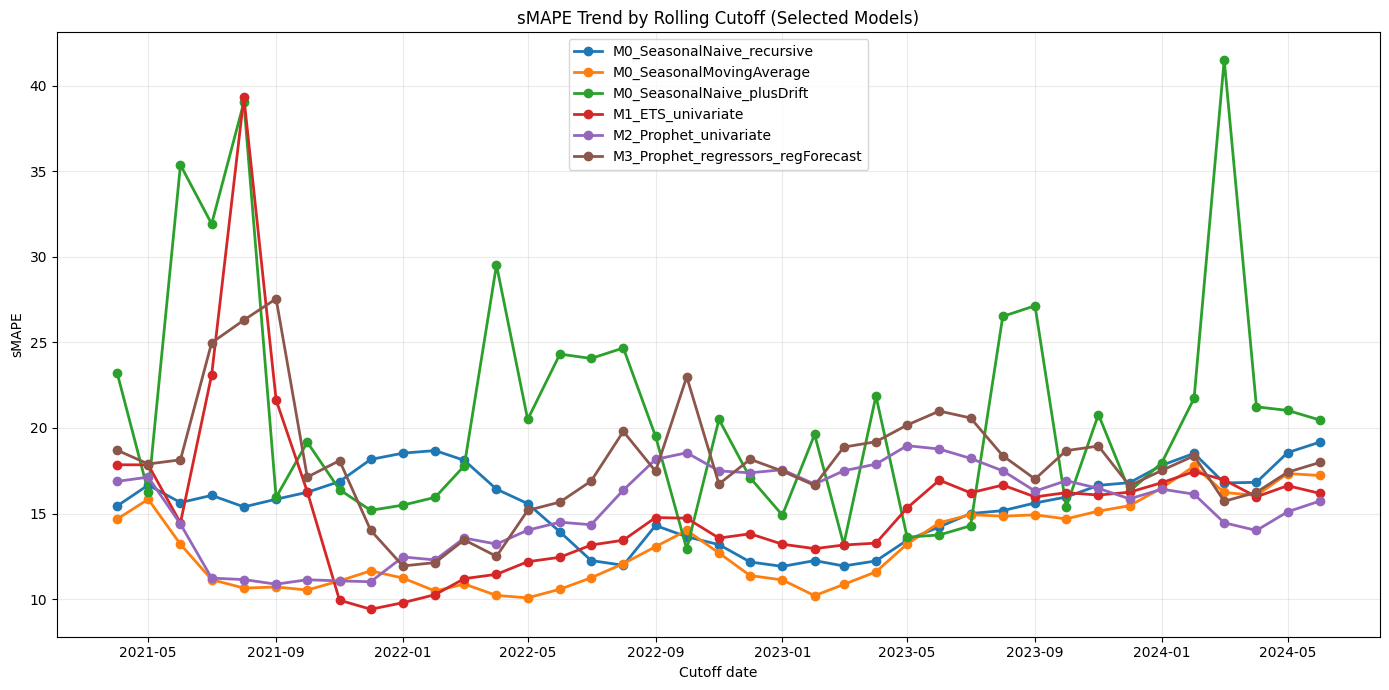

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- Paths ----
BASE_DIR = r"\\Sherwood\accounting\Share\Finance Meetings & Reports\Monthly Reports\BCM Report Monthly\Power BI Report\Forecasting Method - Prophet\Output"
DETAIL_CSV = os.path.join(BASE_DIR, "backtest_detail.csv")

# ---- Choose which models to plot (edit this list) ----
MODELS_TO_PLOT = [
    "M0_SeasonalNaive_recursive",
    "M0_SeasonalMovingAverage",
    "M0_SeasonalNaive_plusDrift",
    "M1_ETS_univariate",
    "M2_Prophet_univariate",
    "M3_Prophet_regressors_regForecast",
]

# (Optional) if you want to avoid legend clutter, set to False
SHOW_LEGEND = True

# -----------------------------
# Read + prep
# -----------------------------
detail = pd.read_csv(DETAIL_CSV)
detail["cutoff"] = pd.to_datetime(detail["cutoff"])
detail["sMAPE"] = pd.to_numeric(detail["sMAPE"], errors="coerce")
detail["ok"] = detail["ok"].astype(bool)

# Keep valid rows + selected models
dfp = detail[(detail["ok"] == True) & np.isfinite(detail["sMAPE"].values)].copy()
dfp = dfp[dfp["model"].isin(MODELS_TO_PLOT)].copy()

# Pivot to cutoff x model (mean in case of duplicates)
smape_pivot = (
    dfp.pivot_table(index="cutoff", columns="model", values="sMAPE", aggfunc="mean")
       .sort_index()
)

# -----------------------------
# Plot (single figure)
# -----------------------------
plt.figure(figsize=(14, 7))

for m in MODELS_TO_PLOT:
    if m in smape_pivot.columns:
        plt.plot(smape_pivot.index, smape_pivot[m], marker="o", linewidth=2, label=m)

plt.title("sMAPE Trend by Rolling Cutoff (Selected Models)")
plt.xlabel("Cutoff date")
plt.ylabel("sMAPE")
plt.grid(True, alpha=0.25)

if SHOW_LEGEND:
    plt.legend()

plt.tight_layout()
plt.show()


In [41]:
import os
import numpy as np
import pandas as pd

BASE_DIR = r"\\Sherwood\accounting\Share\Finance Meetings & Reports\Monthly Reports\BCM Report Monthly\Power BI Report\Forecasting Method - Prophet"
DETAIL_CSV = os.path.join(BASE_DIR, "backtest_detail.csv")

START = "2024-01-01"   # check winners from Jan 2024 onward
H = 18                # your horizon

detail = pd.read_csv(DETAIL_CSV)
detail["cutoff"] = pd.to_datetime(detail["cutoff"])
detail["sMAPE"] = pd.to_numeric(detail["sMAPE"], errors="coerce")
detail["RMSE"]  = pd.to_numeric(detail["RMSE"], errors="coerce")
detail["ok"]    = detail["ok"].astype(bool)

ok = detail[detail["ok"] & np.isfinite(detail["sMAPE"])].copy()

# Winner per cutoff (min sMAPE; tie-break RMSE)
winners = (ok.sort_values(["cutoff","sMAPE","RMSE"])
             .groupby("cutoff", as_index=False)
             .first()[["cutoff","model","sMAPE","RMSE"]]
             .sort_values("cutoff"))

recent_winners = winners[winners["cutoff"] >= pd.Timestamp(START)].copy()

print("Cutoff range in file:", winners["cutoff"].min().date(), "->", winners["cutoff"].max().date())
print("Recent winner counts since", START)
print(recent_winners["model"].value_counts())

# How "recent" is the last cutoff relative to last actual (approx):
last_actual = ok["test_end"].max() if "test_end" in ok.columns else None
if last_actual is not None:
    last_actual = pd.to_datetime(last_actual)
    print("\nLast cutoff:", winners['cutoff'].max().date())
    print("Last test_end (last actual used):", last_actual.date())
    print("Gap (months) ~= ", (last_actual.to_period("M") - winners['cutoff'].max().to_period("M")).n)

# Optional: average winning sMAPE in the recent period
print("\nAverage winning sMAPE since", START, ":", recent_winners["sMAPE"].mean())


Cutoff range in file: 2021-04-01 -> 2024-06-01
Recent winner counts since 2024-01-01
model
M2_Prophet_univariate    6
Name: count, dtype: int64

Last cutoff: 2024-06-01
Last test_end (last actual used): 2025-12-01
Gap (months) ~=  18

Average winning sMAPE since 2024-01-01 : 15.311450976577206


In [42]:
START = "2024-01-01"

recent = ok[ok["cutoff"] >= pd.Timestamp(START)].copy()
top2 = (recent.sort_values(["cutoff","sMAPE","RMSE"])
              .groupby("cutoff", as_index=False)
              .head(2))

# rank within cutoff
top2["rank"] = top2.groupby("cutoff")["sMAPE"].rank(method="first")
best = top2[top2["rank"] == 1].set_index("cutoff")
second = top2[top2["rank"] == 2].set_index("cutoff")

margins = (second["sMAPE"] - best["sMAPE"]).dropna()

print("Avg (2nd - best) sMAPE margin since", START, ":", margins.mean())
print("Median margin:", margins.median())
print("Share of cutoffs where best beats 2nd by >= 0.5 sMAPE:", (margins >= 0.5).mean())
print("Share of cutoffs where best beats 2nd by >= 1.0 sMAPE:", (margins >= 1.0).mean())


Avg (2nd - best) sMAPE margin since 2024-01-01 : 1.0978867550162057
Median margin: 1.2874728487831213
Share of cutoffs where best beats 2nd by >= 0.5 sMAPE: 0.6666666666666666
Share of cutoffs where best beats 2nd by >= 1.0 sMAPE: 0.6666666666666666


In [43]:
recent_winners = winners[winners["cutoff"] >= pd.Timestamp("2024-01-01")]
recent_winners["model"].value_counts(), recent_winners.shape[0]


(model
 M2_Prophet_univariate    6
 Name: count, dtype: int64,
 6)